In [1]:
import os

if os.name == 'nt':
    %env DOC=C:\Users\BK\Documents
else:
    %env DOC=/Users/muuzh/Documents

from AMI import automutual_info_single, automutual_info, automutual_info_k1

env: DOC=C:\Users\BK\Documents
C:\Users\BK\Documents\JIDT\infodynamics.jar


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import seaborn as sns
import pandas as pd
import time
import itertools
import scipy.stats as stats
import jpype
import datasets as datasets
import matplotlib.gridspec as gridspec
import measures as nolds



In [3]:
def poincare_plot(data, stride=1):
    x = data[:-stride]
    y = data[stride:]
    return x, y

In [4]:
a_num = 500

lag1para = np.linspace(-1, 1, a_num)
ARpara = [np.r_[1, -arparams] for arparams in lag1para]
series_length = 2000

# Generate data
ARmatrix = np.array([ArmaProcess(ar, [1]).generate_sample(nsample=series_length) for ar in tqdm(ARpara)])


  0%|          | 0/500 [00:00<?, ?it/s]

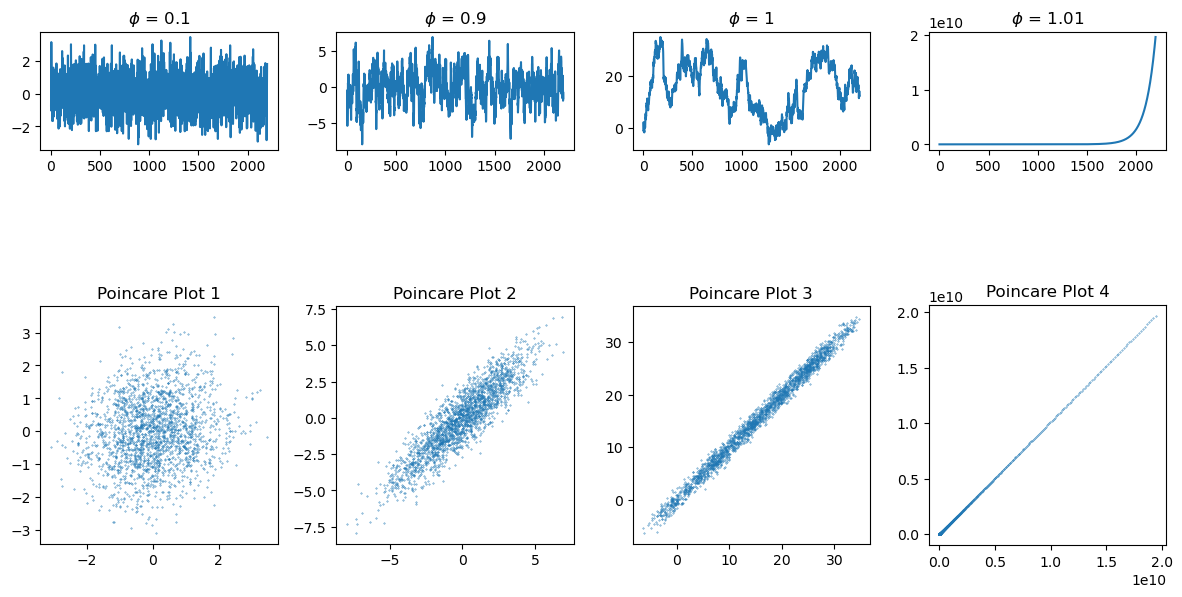

In [28]:
p1 =  0.1
p2 =  0.9
p3 =  1
p4 = 1.01
s1 = ArmaProcess(np.r_[1, -p1], [1]).generate_sample(nsample=series_length)
s2 = ArmaProcess(np.r_[1, -p2], [1]).generate_sample(nsample=series_length)
s3 = ArmaProcess(np.r_[1, -p3], [1]).generate_sample(nsample=series_length)
s4 = ArmaProcess(np.r_[1, -p4], [1]).generate_sample(nsample=series_length)

# plt.plot(s3)



In [4]:
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 4], left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.3, hspace=-0.05)
plt.style.use("seaborn")

fig = plt.figure(figsize=(10, 4))
params = [p1, p2, p3 ,p4]
series = [s1, s2, s3 ,s4]
series = np.array(series)
series = series[:,:2000]

for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    ax.set_title(f'$\phi$ = {params[i]}')
    ax.plot(series[i])
    if i == 0:
        ax.set_ylabel('X(t)')
    ax.set_xlabel('t')


for i in range(4):
    ax = fig.add_subplot(gs[1, i])
    ax.scatter(*poincare_plot(series[i]), s=0.8)
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('X(t+1)')
    ax.set_xlabel('X(t)')

plt.savefig('AR_demo.eps', format='eps', dpi=1000)
plt.show()

NameError: name 'p1' is not defined

<Figure size 1000x400 with 0 Axes>

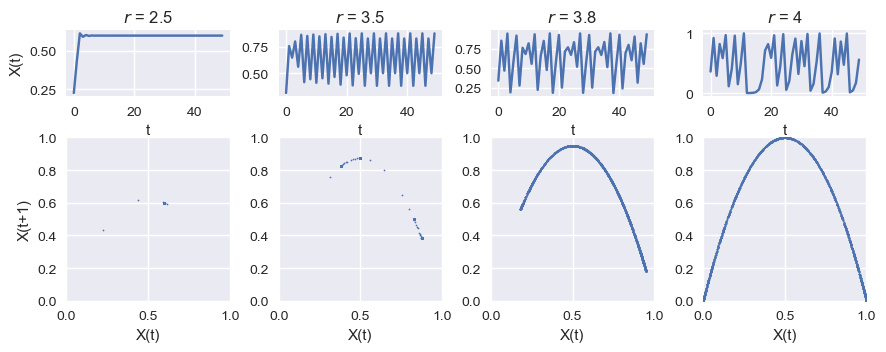

In [23]:
x_start = 0.1
series_length = 2000
logistic_num = tent_a_num = 100

param_range_logistic = np.linspace(3.57, 4, logistic_num)

lo_ps = [2.5 ,3.5, 3.8, 4]

lo_series = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in lo_ps
])

plotrange = 50


fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 4], left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.3, hspace=-0.05)
plt.style.use("seaborn")

for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    ax.set_title(f'$r$ = {lo_ps[i]}')
    ax.plot(lo_series[i][:plotrange])
    if i == 0:
        ax.set_ylabel('X(t)')
    ax.set_xlabel('t')


for i in range(4):
    ax = fig.add_subplot(gs[1, i])
    ax.scatter(*poincare_plot(lo_series[i]), s=0.8)
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('X(t+1)')
    ax.set_xlabel('X(t)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
plt.savefig('logistic_demo.eps', format='eps', dpi=1000)
plt.show()


In [41]:
def plot_lyap(maptype):
  # local import to avoid dependency for non-debug use
  import matplotlib.pyplot as plt

  x_start = 0.1
  n = 140
  nbifur = 40
  if maptype == "logistic":
    param_name = "r"
    param_range = np.arange(2, 4, 0.01)
    full_data = np.array([
      np.fromiter(datasets.logistic_map(x_start, n, r), dtype="float32")
      for r in param_range
    ])

    lambdas = [
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(full_data, param_range)
    ]
  elif maptype == "tent":
    param_name = "$\\mu$"
    param_range = np.arange(0, 2, 0.01)
    full_data = np.array([
      np.fromiter(datasets.tent_map(x_start, n, mu), dtype="float32")
      for mu in param_range
    ])

    lambdas = np.log(param_range, where=param_range > 0)
    lambdas[np.where(param_range <= 0)] = np.nan
  else:
    # raise Error("maptype %s not recognized" % maptype)
    pass

  kwargs_e = {"emb_dim": 6, "matrix_dim": 2}
  kwargs_r = {"emb_dim": 6, "lag": 2, "min_tsep": 20, "trajectory_len": 20}
  # algorithm of Eckmann
  lambdas_e = [max(nolds.lyap_e(d, **kwargs_e)) for d in full_data]
  # ################
  # 
  # algorithm of Rosenstein
  # lambdas_r = [nolds.lyap_r(d, **kwargs_r) for d in full_data]
  # ################
  # bifur_x = np.repeat(param_range, nbifur)
  # bifur = np.reshape(full_data[:, -nbifur:], nbifur * param_range.shape[0])

  plt.figure(figsize=(10, 6))
  plt.title("Lyapunov exponent of %s map" % maptype)
  plt.plot(param_range, lambdas, "b-", label="Analytical Lyapunov exponent")
  elab = "Eckmann method"
  # rlab = "largest LE, Rosenstein method"
  plt.plot(param_range, lambdas_e, color="#00AAAA", label=elab)
  # plt.plot(param_range, lambdas_r, color="#AA00AA", label=rlab)
  plt.plot(param_range, np.zeros(len(param_range)), "g--")
  # plt.plot(bifur_x, bifur, "ro", alpha=0.1, label="bifurcation plot")
  plt.ylim((-2, 2))
  plt.xlabel(param_name)
  plt.ylabel("LE")
  plt.legend(loc="best")
  # plt.savefig(f'{maptype}_lyap.eps', format='eps', dpi=1000)
  plt.show()

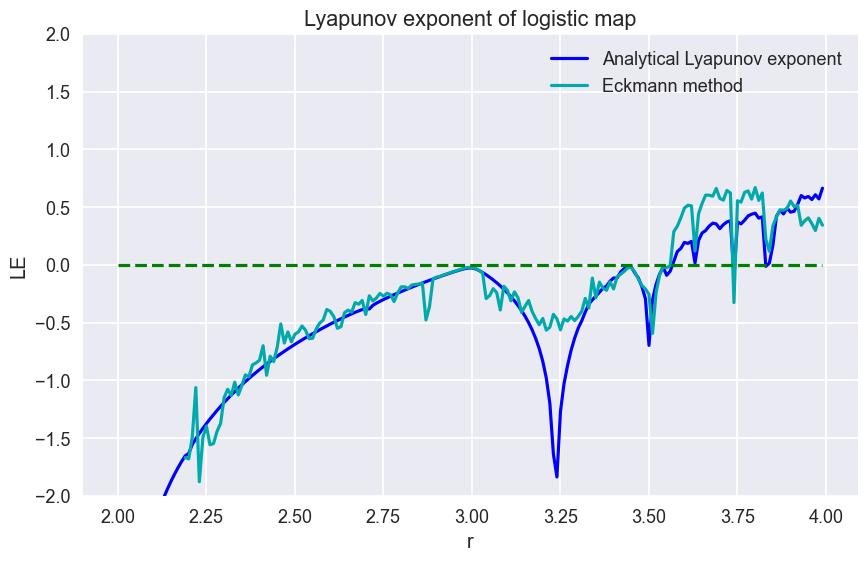

In [42]:
# plot_lyap("tent")
plot_lyap("logistic")

In [33]:
def plot_lyap_theo(maptype):
  # local import to avoid dependency for non-debug use
  import matplotlib.pyplot as plt

  x_start = 0.1
  n = 140
  nbifur = 40
  if maptype == "logistic":
    param_name = "r"
    param_range = np.arange(2, 4, 0.01)
    full_data = np.array([
      np.fromiter(datasets.logistic_map(x_start, n, r), dtype="float32")
      for r in param_range
    ])

    lambdas = [
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(full_data, param_range)
    ]
  elif maptype == "tent":
    param_name = "$\\mu$"
    param_range = np.arange(0, 2, 0.01)
    full_data = np.array([
      np.fromiter(datasets.tent_map(x_start, n, mu), dtype="float32")
      for mu in param_range
    ])

    lambdas = np.log(param_range, where=param_range > 0)
    lambdas[np.where(param_range <= 0)] = np.nan
  else:
    # raise Error("maptype %s not recognized" % maptype)
    pass

  

  plt.figure(figsize=(10, 6))
  # plt.title("Lyapunov exponent of %s map" % maptype)
  plt.plot(param_range, lambdas, label="Lyapunov Exponent")

  plt.plot(param_range, np.zeros(len(param_range)), "g--")
#   plt.plot(bifur_x, bifur, "ro", alpha=0.1, label="bifurcation plot")
  plt.ylim((-2, 2))
  plt.xlabel(param_name)
  plt.ylabel("Lyapunov Exponent")
  # plt.legend(loc="best")
  plt.show()

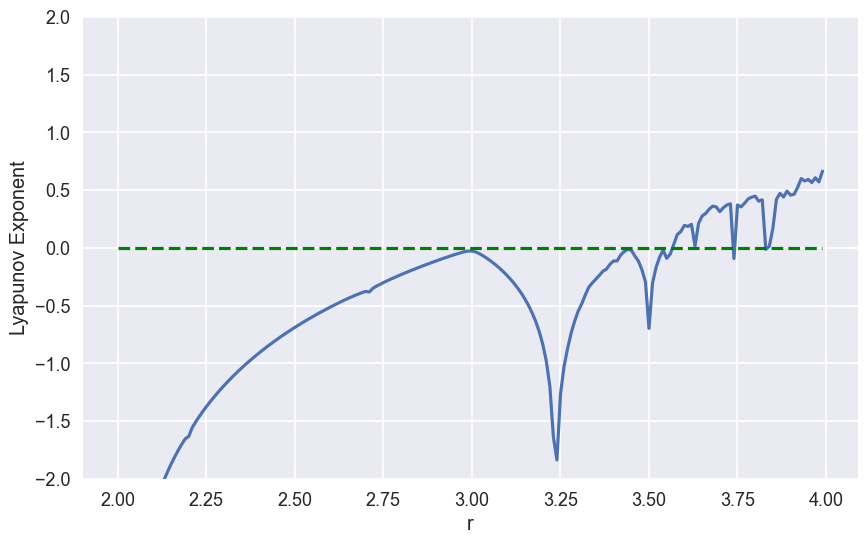

In [34]:
plot_lyap_theo("logistic")


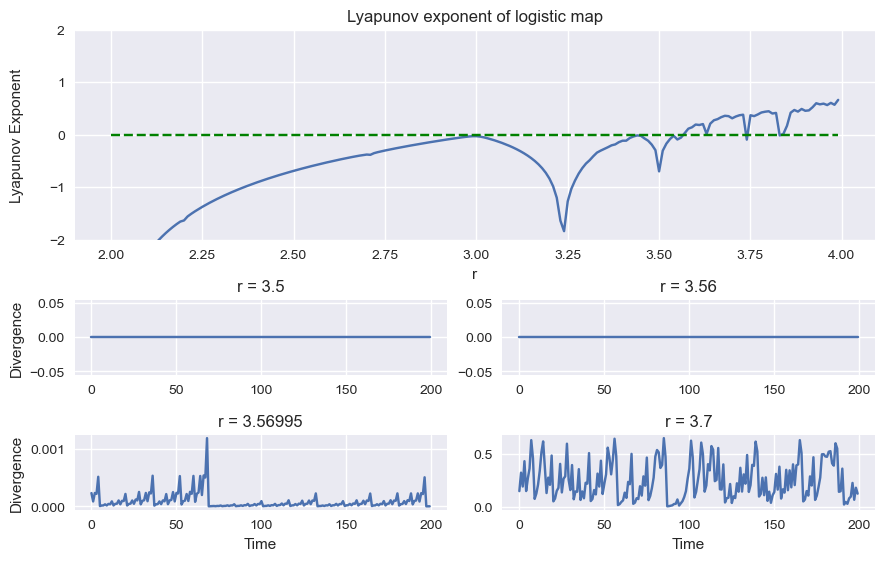

In [112]:
x_start = 0.1
n = 140
param_name = "r"
param_range = np.arange(2, 4, 0.01)
full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, n, r), dtype="float32")
    for r in param_range
])

lambdas = [
    np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
    for x, r in zip(full_data, param_range)
]





# plt.figure(figsize=(10, 6))
# plt.plot(param_range, lambdas, label="Lyapunov Exponent")

# plt.plot(param_range, np.zeros(len(param_range)), "g--")
# plt.show()
#   plt.plot(bifur_x, bifur, "ro", alpha=0.1, label="bifurcation plot")
# plt.ylim((-2, 2))
# plt.xlabel(param_name)
# plt.ylabel("Lyapunov Exponent")


fig = plt.figure(figsize= (10, 6))
gs = gridspec.GridSpec(4, 2, left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.15, hspace=0.8)

ax = fig.add_subplot(gs[0:2, :])
ax.plot(param_range, lambdas, label="Lyapunov Exponent")
ax.plot(param_range, np.zeros(len(param_range)), "g--")
ax.set_ylabel("Lyapunov Exponent")
ax.set_xlabel(param_name)
ax.set_ylim((-2, 2))
ax.set_title("Lyapunov exponent of logistic map")





def logistic(r, x):
    return r * x * (1 - x)

# Initial conditions
x0 = 0.1
x1 = x0 + 1e-6

# Number of iterations to discard before plotting
discard_iterations = 1000

# Number of iterations to plot
plot_iterations = 1000

# Control parameters
r_values = [3.5, 3.56, 3.56995, 3.7]

row = 2
col = 0
for i in range(4):
    ax = fig.add_subplot(gs[row, col])
    r = r_values[i]
    
    # Generate trajectories
    x0_values = np.empty(plot_iterations)
    x1_values = np.empty(plot_iterations)
    
    x0_values[0] = logistic(r, x0)
    x1_values[0] = logistic(r, x1)
    
    # Discard some iterations
    for _ in range(discard_iterations):
        x0_values[0] = logistic(r, x0_values[0])
        x1_values[0] = logistic(r, x1_values[0])
        
    # Generate remaining iterations
    for j in range(1, plot_iterations):
        x0_values[j] = logistic(r, x0_values[j-1])
        x1_values[j] = logistic(r, x1_values[j-1])
        
    ax.plot(np.abs(x1_values - x0_values)[:200])
    ax.set_title(f'r = {r}')
    if row == 3:
        ax.set_xlabel('Time')
    if col == 0:
        ax.set_ylabel('Divergence')
    col += 1
    if i == 1:
        row += 1
        col = 0

fig.align_labels() 
plt.savefig('lyp_demo.eps', format='eps', dpi=1000)
plt.show()

In [89]:
series_length = 2000
p1 =  0
p2 =  -0.91

s1 = ArmaProcess(np.r_[1, -p1], [1]).generate_sample(nsample=series_length)
s2 = ArmaProcess(np.r_[1, -p2], [1]).generate_sample(nsample=series_length)


x_start = 0.1

lo_ps = [3.6, 4]
lo_series = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length+200, r), dtype="float32")
    for r in lo_ps
])

lo_series = lo_series[:, 200:]





logistic_num = 400

logistic_param = np.linspace(3.57, 4, logistic_num)

logistic_full_data = np.array([
      np.fromiter(datasets.logistic_map(x_start, series_length+200, r), dtype="float32")
      for r in logistic_param
    ])

logistic_full_data = logistic_full_data[:, 200:]


logistic_lambdas = np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, logistic_param)
    ])

valid_logistic_param = logistic_param[np.where(logistic_lambdas > 0)]
valid_logistic_data = logistic_full_data[np.where(logistic_lambdas > 0)]

Logistic_AC1 = np.array([
    acf(series, nlags=1)[1]
    for series in valid_logistic_data
])


a_num = 400
lag1para = np.linspace(0, 1, a_num)

ARpara = [np.r_[1, -arparams] for arparams in lag1para]


AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(series_length) for ar in ARpara])

AR1AC1 = np.array([
    acf(series, nlags=1)[1]
    for series in AR1matrix
])






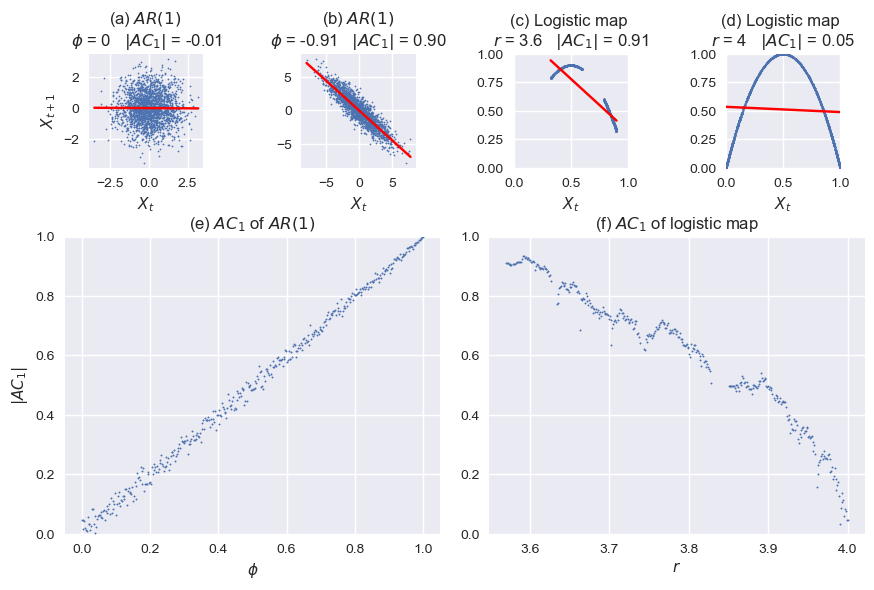

In [90]:
fig = plt.figure(figsize= (10, 6))
gs = gridspec.GridSpec(6, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.3, hspace=3)
plt.style.use("seaborn")

ax0 = fig.add_subplot(gs[0:2, 0])
ax0.scatter(*poincare_plot(s1), s=0.8)
ax0.plot(np.unique(s1[:-1]), np.poly1d(np.polyfit(s1[:-1], s1[1:], 1))(np.unique(s1[:-1])), color='red')
AC1temp = acf(s1, nlags=1)[1]
ax0.set_aspect('equal')
ax0.set_ylabel(r'$X_{t+1}$')
ax0.set_xlabel(r'$X_t$')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax0.set_title(f'(a) $AR(1)$ \n$\phi$ = {p1}   $|AC_1|$ = {AC1temp:.2f}')


ax1 = fig.add_subplot(gs[0:2, 1])
ax1.scatter(*poincare_plot(s2), s=0.8)
ax1.plot(np.unique(s2[:-1]), np.poly1d(np.polyfit(s2[:-1], s2[1:], 1))(np.unique(s2[:-1])), color='red')
AC1temp = acf(s2, nlags=1)[1]
ax1.set_aspect('equal')
# ax1.set_ylabel(r'$X_{t+1}$')
ax1.set_xlabel(r'$X_t$')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax1.set_title(f'(b) $AR(1)$ \n$\phi$ = {p2}   $|AC_1|$ = {np.abs(AC1temp):.2f}')



ax2 = fig.add_subplot(gs[0:2, 2])
ax2.scatter(*poincare_plot(lo_series[0]), s=0.8)
ax2.plot(np.unique(lo_series[0][:-1]), np.poly1d(np.polyfit(lo_series[0][:-1], lo_series[0][1:], 1))(np.unique(lo_series[0][:-1])), color='red')
AC1temp = acf(lo_series[0], nlags=1)[1]
ax2.set_aspect('equal')
# ax2.set_ylabel(r'$X_{t+1}$')
ax2.set_xlabel(r'$X_t$')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title(f'(c) Logistic map \n$r$ = {lo_ps[0]}   $|AC_1|$ = {np.abs(AC1temp):.2f}')

ax3 = fig.add_subplot(gs[0:2, 3])
ax3.scatter(*poincare_plot(lo_series[1]), s=0.8)
ax3.plot(np.unique(lo_series[1][:-1]), np.poly1d(np.polyfit(lo_series[1][:-1], lo_series[1][1:], 1))(np.unique(lo_series[1][:-1])), color='red')
AC1temp = acf(lo_series[1], nlags=1)[1]
ax3.set_aspect('equal')
# ax3.set_ylabel(r'$X_{t+1}$')
ax3.set_xlabel(r'$X_t$')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_title(f'(d) Logistic map \n$r$ = {lo_ps[1]}   $|AC_1|$ = {np.abs(AC1temp):.2f}')

ax4 = fig.add_subplot(gs[2:6, 0:2])
ax4.scatter(lag1para, np.abs(AR1AC1), s=1)
ax4.set_xlabel(r'$\phi$')
ax4.set_ylabel(r'$|AC_1|$')
ax4.set_title('(e) $AC_1$ of $AR(1)$')
ax4.set_ylim(0, 1)

ax5 = fig.add_subplot(gs[2:6, 2:4], sharey = ax4)
ax5.scatter(valid_logistic_param, np.abs(Logistic_AC1), s=1)
ax5.set_xlabel(r'$r$')
# ax5.set_ylabel(r'$|AC_1|$')
ax5.set_title('(f) $AC_1$ of logistic map')
ax5.set_ylim(0, 1)

plt.savefig('AC1_demo.eps', format='eps', dpi=1000)
plt.show()



In [57]:
print(logistic_full_data.shape)
print(valid_logistic_data.shape)



(400, 2000)
(365, 2000)


In [5]:
series_length = 2000





logistic_num = 400

logistic_param = np.linspace(3.57, 4, logistic_num)

logistic_full_data = np.array([
      np.fromiter(datasets.logistic_map(x_start, series_length+200, r), dtype="float32")
      for r in logistic_param
    ])

logistic_full_data = logistic_full_data[:, 200:]


logistic_lambdas = np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, logistic_param)
    ])

valid_logistic_param = logistic_param[np.where(logistic_lambdas > 0)]
valid_logistic_data = logistic_full_data[np.where(logistic_lambdas > 0)]


Logistic_AMI1 = automutual_info(valid_logistic_data, 1, 3)

a_num = 400
lag1para = np.linspace(0, 1, a_num)

ARpara = [np.r_[1, -arparams] for arparams in lag1para]
# For each parameter, generate 20 AR time series
# Use a 3d numpy array to store the results, with placeholder nan

AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(series_length) for ar in ARpara])

AR1AMI1 = automutual_info(AR1matrix, 1, 3)





Processing:   0%|          | 0/364 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

Processing:   0%|          | 0/1.0 [00:00<?, ?it/s]

Processing:   0%|          | 0/1.0 [00:00<?, ?it/s]

Processing:   0%|          | 0/1.0 [00:00<?, ?it/s]

Processing:   0%|          | 0/1.0 [00:00<?, ?it/s]

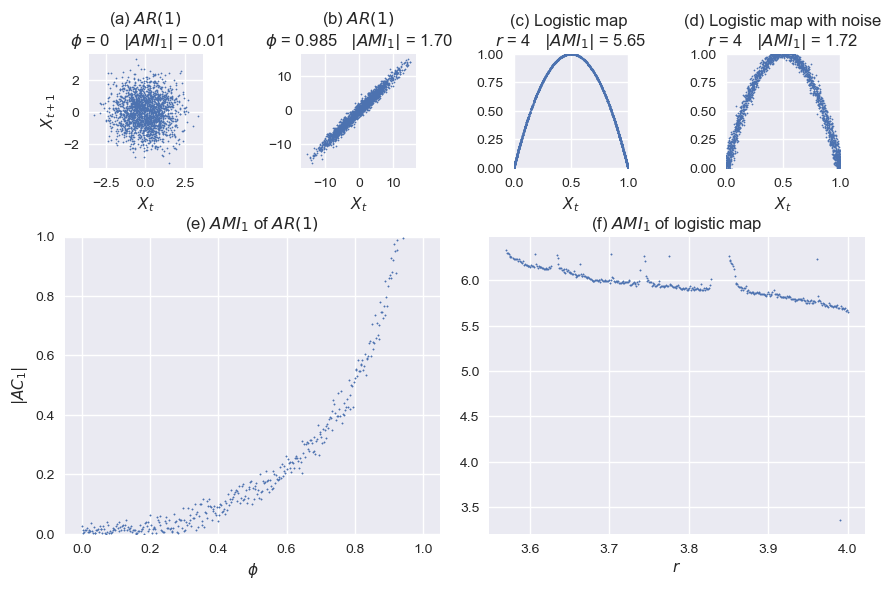

In [34]:
p1 =  0
p2 =  0.985

s1 = ArmaProcess(np.r_[1, -p1], [1]).generate_sample(nsample=series_length)
s2 = ArmaProcess(np.r_[1, -p2], [1]).generate_sample(nsample=series_length)


x_start = 0.1

lo_ps = [4, 4]
lo_series = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length+200, r), dtype="float32")
    for r in lo_ps
])

lo_series = lo_series[:, 200:]


fig = plt.figure(figsize= (10, 6))
gs = gridspec.GridSpec(6, 4, left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.3, hspace=3)
plt.style.use("seaborn")

ax0 = fig.add_subplot(gs[0:2, 0])
ax0.scatter(*poincare_plot(s1), s=0.8)
# ax0.plot(np.unique(s1[:-1]), np.poly1d(np.polyfit(s1[:-1], s1[1:], 1))(np.unique(s1[:-1])), color='red')
AMI1temp = automutual_info(s1, 1, 3)
ax0.set_aspect('equal')
ax0.set_ylabel(r'$X_{t+1}$')
ax0.set_xlabel(r'$X_t$')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax0.set_title(f'(a) $AR(1)$ \n$\phi$ = {p1}   $|AMI_1|$ = {AMI1temp:.2f}')


ax1 = fig.add_subplot(gs[0:2, 1])
ax1.scatter(*poincare_plot(s2), s=0.8)
# ax1.plot(np.unique(s2[:-1]), np.poly1d(np.polyfit(s2[:-1], s2[1:], 1))(np.unique(s2[:-1])), color='red')
AMI1temp = automutual_info(s2, 1, 3)
ax1.set_aspect('equal')
# ax1.set_ylabel(r'$X_{t+1}$')
ax1.set_xlabel(r'$X_t$')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax1.set_title(f'(b) $AR(1)$ \n$\phi$ = {p2}   $|AMI_1|$ = {np.abs(AMI1temp):.2f}')



ax2 = fig.add_subplot(gs[0:2, 2])
ax2.scatter(*poincare_plot(lo_series[0]), s=0.8)
# ax2.plot(np.unique(lo_series[0][:-1]), np.poly1d(np.polyfit(lo_series[0][:-1], lo_series[0][1:], 1))(np.unique(lo_series[0][:-1])), color='red')
AMI1temp = automutual_info(lo_series[0] , 1, 3)

ax2.set_aspect('equal')
# ax2.set_ylabel(r'$X_{t+1}$')
ax2.set_xlabel(r'$X_t$')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title(f'(c) Logistic map \n$r$ = {lo_ps[0]}   $|AMI_1|$ = {np.abs(AMI1temp):.2f}')

ax3 = fig.add_subplot(gs[0:2, 3])
# ax3.plot(np.unique(lo_series[1][:-1]), np.poly1d(np.polyfit(lo_series[1][:-1], lo_series[1][1:], 1))(np.unique(lo_series[1][:-1])), color='red')
# noise term
noise = np.random.normal(0, 0.02, len(lo_series[1]))

lo_series[1] = lo_series[1] + noise
ax3.scatter(*poincare_plot(lo_series[1]), s=0.8)
AMI1temp = automutual_info(lo_series[1], 1, 3)
ax3.set_aspect('equal')
# ax3.set_ylabel(r'$X_{t+1}$')
ax3.set_xlabel(r'$X_t$')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_title(f'(d) Logistic map with noise\n$r$ = {lo_ps[1]}   $|AMI_1|$ = {np.abs(AMI1temp):.2f}')

ax4 = fig.add_subplot(gs[2:6, 0:2])
ax4.scatter(lag1para, np.abs(AR1AMI1), s=1)
ax4.set_xlabel(r'$\phi$')
ax4.set_ylabel(r'$|AC_1|$')
ax4.set_title('(e) $AMI_1$ of $AR(1)$')
ax4.set_ylim(0, 1)

ax5 = fig.add_subplot(gs[2:6, 2:4])
ax5.scatter(valid_logistic_param, Logistic_AMI1, s=1)
ax5.set_xlabel(r'$r$')
# ax5.set_ylabel(r'$|AC_1|$')
ax5.set_title('(f) $AMI_1$ of logistic map')
# ax5.set_ylim(0, 1)

plt.savefig('AMI1_demo.eps', format='eps', dpi=1000)
plt.show()



In [4]:
series_length = 2000
x_start = 0.1
logistic_num = 400

logistic_param = np.linspace(3.57, 4, logistic_num)

logistic_full_data = np.array([
      np.fromiter(datasets.logistic_map(x_start, series_length+200, r), dtype="float32")
      for r in logistic_param
    ])

logistic_full_data = logistic_full_data[:, 200:]


logistic_lambdas = np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, logistic_param)
    ])

valid_logistic_param = logistic_param[np.where(logistic_lambdas > 0)]
valid_logistic_data = logistic_full_data[np.where(logistic_lambdas > 0)]


Logistic_AMI1 = automutual_info(valid_logistic_data, 1, 3)

a_num = 400
lag1para = np.linspace(0, 1, a_num)

ARpara = [np.r_[1, -arparams] for arparams in lag1para]
# For each parameter, generate 20 AR time series
# Use a 3d numpy array to store the results, with placeholder nan

AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(series_length) for ar in ARpara])

AR1AMI1 = automutual_info(AR1matrix, 1, 3)

Logistic_AC1 = np.array([
    acf(series, nlags=1)[1]
    for series in valid_logistic_data
])

AR1AC1 = np.array([
    acf(series, nlags=1)[1]
    for series in AR1matrix
])



Processing:   0%|          | 0/364 [00:00<?, ?it/s]

Processing:   0%|          | 0/400 [00:00<?, ?it/s]

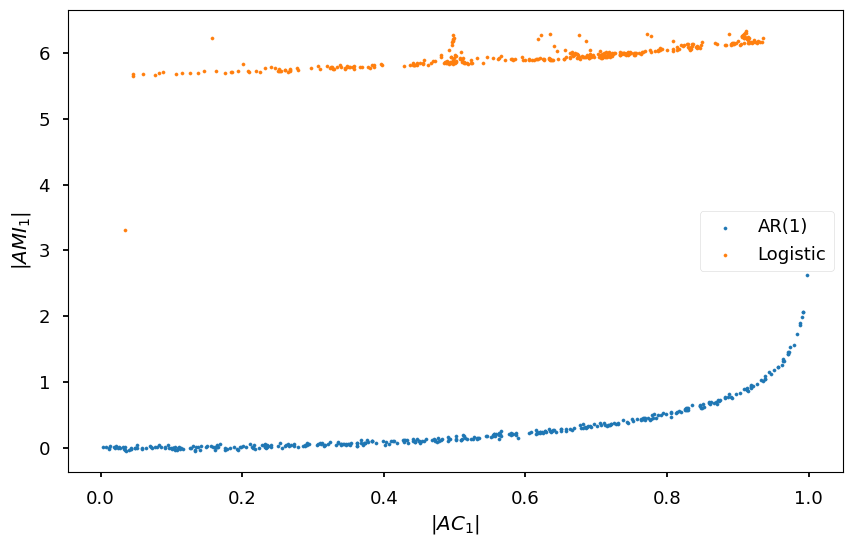

In [5]:
plt.style.use("seaborn-talk")
plt.figure(figsize=(10, 6))
plt.scatter(np.abs(AR1AC1), AR1AMI1, s=5, label='AR(1)')
plt.scatter(np.abs(Logistic_AC1), Logistic_AMI1, s=5, label='Logistic')
plt.xlabel(r'$|AC_1|$')
plt.ylabel(r'$|AMI_1|$')
plt.legend()


In [11]:
#! /usr/bin/env python3
"""
iaaft - Iterative amplitude adjusted Fourier transform surrogates

        This module implements the IAAFT method [1] to generate time series
        surrogates (i.e. randomized copies of the original time series) which
        ensures that each randomised copy preserves the power spectrum of the
        original time series.

[1] Venema, V., Ament, F. & Simmer, C. A stochastic iterative amplitude
    adjusted Fourier Transform algorithm with improved accuracy (2006), Nonlin.
    Proc. Geophys. 13, pp. 321--328
    https://doi.org/10.5194/npg-13-321-2006

"""
# Created: Tue Jun 22, 2021  09:44am
# Last modified: Tue Jun 22, 2021  12:39pm
#
# Copyright (C) 2021  Bedartha Goswami <bedartha.goswami@uni-tuebingen.de> This
# program is free software: you can redistribute it and/or modify it under the
# terms of the GNU Affero General Public License as published by the Free
# Software Foundation, either version 3 of the License, or (at your option) any
# later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------


def surrogates(x, ns, tol_pc=5., verbose=True, maxiter=1E6, sorttype="quicksort"):
    """
    Returns iAAFT surrogates of given time series.

    Parameter
    ---------
    x : numpy.ndarray, with shape (N,)
        Input time series for which IAAFT surrogates are to be estimated.
    ns : int
        Number of surrogates to be generated.
    tol_pc : float
        Tolerance (in percent) level which decides the extent to which the
        difference in the power spectrum of the surrogates to the original
        power spectrum is allowed (default = 5).
    verbose : bool
        Show progress bar (default = `True`).
    maxiter : int
        Maximum number of iterations before which the algorithm should
        converge. If the algorithm does not converge until this iteration
        number is reached, the while loop breaks.
    sorttype : string
        Type of sorting algorithm to be used when the amplitudes of the newly
        generated surrogate are to be adjusted to the original data. This
        argument is passed on to `numpy.argsort`. Options include: 'quicksort',
        'mergesort', 'heapsort', 'stable'. See `numpy.argsort` for further
        information. Note that although quick sort can be a bit faster than 
        merge sort or heap sort, it can, depending on the data, have worse case
        spends that are much slower.

    Returns
    -------
    xs : numpy.ndarray, with shape (ns, N)
        Array containing the IAAFT surrogates of `x` such that each row of `xs`
        is an individual surrogate time series.

    See Also
    --------
    numpy.argsort

    """
    # as per the steps given in Lancaster et al., Phys. Rep (2018)
    nx = x.shape[0]
    xs = np.zeros((ns, nx))
    maxiter = 10000
    ii = np.arange(nx)

    # get the fft of the original array
    x_amp = np.abs(np.fft.fft(x))
    x_srt = np.sort(x)
    r_orig = np.argsort(x)

    # loop over surrogate number
    pb_fmt = "{desc:<5.5}{percentage:3.0f}%|{bar:30}{r_bar}"
    pb_desc = "Estimating IAAFT surrogates ..."
    for k in tqdm(range(ns), bar_format=pb_fmt, desc=pb_desc,
                  disable=not verbose):

        # 1) Generate random shuffle of the data
        count = 0
        r_prev = np.random.permutation(ii)
        r_curr = r_orig
        z_n = x[r_prev]
        percent_unequal = 100.

        # core iterative loop
        while (percent_unequal > tol_pc) and (count < maxiter):
            r_prev = r_curr

            # 2) FFT current iteration yk, and then invert it but while
            # replacing the amplitudes with the original amplitudes but
            # keeping the angles from the FFT-ed version of the random
            y_prev = z_n
            fft_prev = np.fft.fft(y_prev)
            phi_prev = np.angle(fft_prev)
            e_i_phi = np.exp(phi_prev * 1j)
            z_n = np.fft.ifft(x_amp * e_i_phi)

            # 3) rescale zk to the original distribution of x
            r_curr = np.argsort(z_n, kind=sorttype)
            z_n[r_curr] = x_srt.copy()
            percent_unequal = ((r_curr != r_prev).sum() * 100.) / nx

            # 4) repeat until number of unequal entries between r_curr and 
            # r_prev is less than tol_pc percent
            count += 1

        if count >= (maxiter - 1):
            print("maximum number of iterations reached!")

        xs[k] = np.real(z_n)

    return xs



Processing:   0%|          | 0/400 [00:00<?, ?it/s]

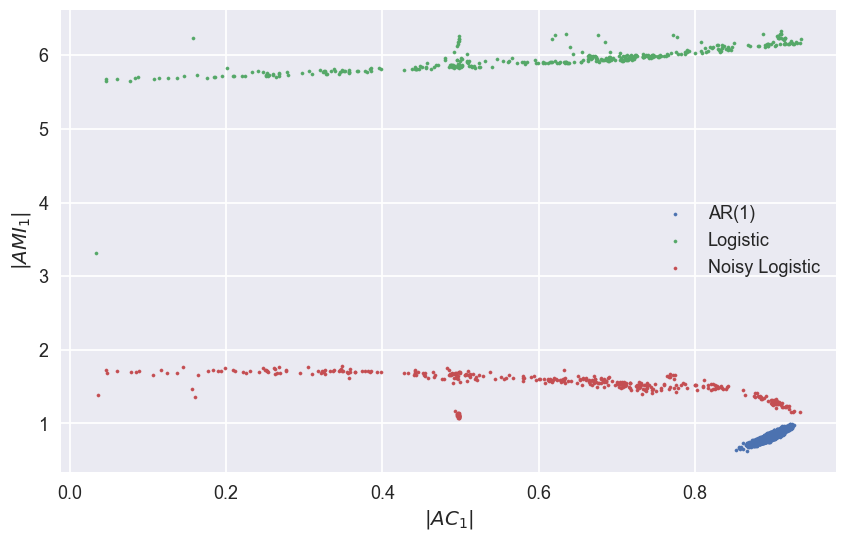

In [57]:
noisy_logistic = logistic_full_data + np.random.normal(0, 0.02, logistic_full_data.shape)
noisy_lo_AC1 = np.array([
    acf(series, nlags=1)[1]
    for series in noisy_logistic
])
noisy_lo_AMI1 = automutual_info(noisy_logistic, 1, 3)
# surro_logistic = np.array([surrogates(series, 1, verbose=False)[0] for series in tqdm(valid_logistic_data)])
# surro_lo_AC1 = np.array([
#     acf(series, nlags=1)[1]
#     for series in surro_logistic
# ])
# surro_lo_AMI1 = automutual_info(surro_logistic, 1, 3)


plt.figure(figsize=(10, 6))
plt.scatter(np.abs(AR1AC1), AR1AMI1, s=5, label='AR(1)')
plt.scatter(np.abs(Logistic_AC1), Logistic_AMI1, s=5, label='Logistic')
plt.scatter(np.abs(noisy_lo_AC1), noisy_lo_AMI1, s=5, label='Noisy Logistic')

plt.xlabel(r'$|AC_1|$')
plt.ylabel(r'$|AMI_1|$')
plt.legend()



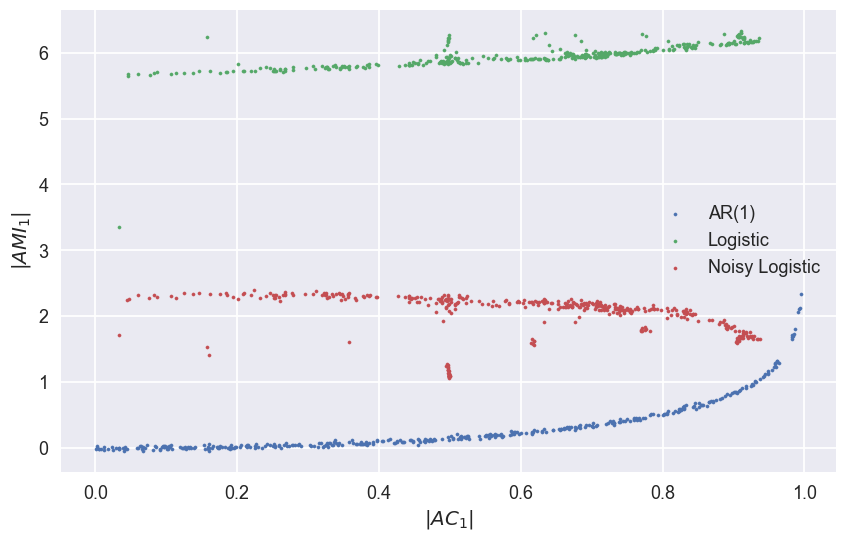

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(np.abs(AR1AC1), AR1AMI1, s=5, label='AR(1)')
plt.scatter(np.abs(Logistic_AC1), Logistic_AMI1, s=5, label='Logistic')
plt.scatter(np.abs(noisy_lo_AC1), noisy_lo_AMI1, s=5, label='Noisy Logistic')

plt.xlabel(r'$|AC_1|$')
plt.ylabel(r'$|AMI_1|$')
plt.legend()
# plt.savefig('AC1_AMI1_space.eps', format='eps', dpi=1000)
plt.show()


Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

(array([   2.,   10.,   81.,  450., 1184., 1617., 1152.,  422.,   72.,
          10.]),
 array([-0.00197318,  0.01651285,  0.03499888,  0.05348492,  0.07197095,
         0.09045699,  0.10894302,  0.12742906,  0.14591509,  0.16440112,
         0.18288716]),
 <BarContainer object of 10 artists>)

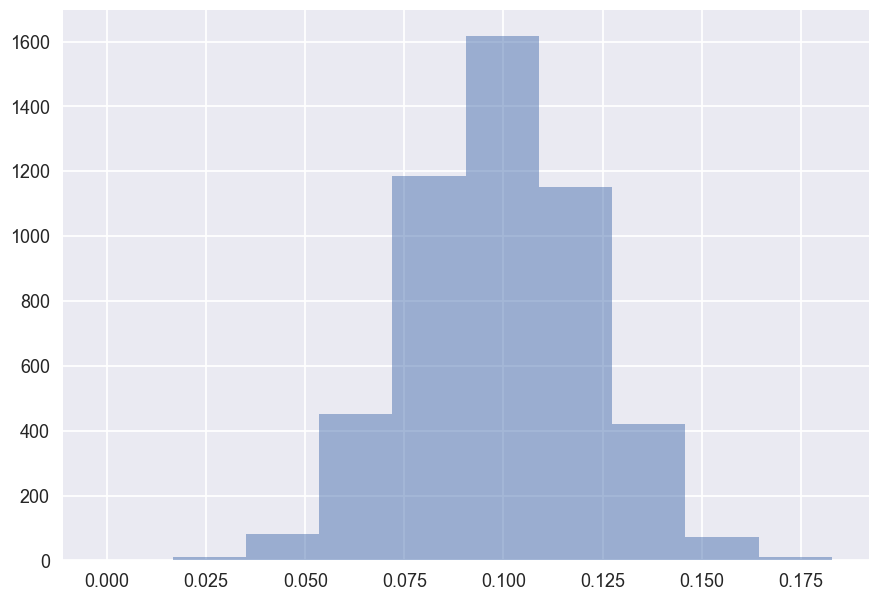

In [29]:
lag1para= [0.1, 0.9]
sample_size = 5000
ARpara = [np.r_[1, -arparams] for arparams in lag1para]
AR_ACAMIresults = []
for ar in ARpara:
    AR1matrix = np.array([ArmaProcess(ar, [1]).generate_sample(series_length) for _ in range(sample_size)])
    AR1AC1 = np.array([
        acf(series, nlags=1)[1]
        for series in AR1matrix
    ])
    AR1AMI1 = automutual_info(AR1matrix, 1, 3)
    AR_ACAMIresults.append([AR1AC1, AR1AMI1])

plt.figure()
plt.hist(AR_ACAMIresults[0][0], bins=10, alpha=0.5, label='AC1')


In [30]:
np.savez('ACAMInormaldistribution.npz', lag1para=lag1para, sample_size=sample_size, AR_ACAMIresults=AR_ACAMIresults)

In [52]:
import matplotlib as mpl
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.use('svg')
new_rc_params = {
    "font.family": 'Times', #probably python doesn't know Times, but it will replace it with a different font anyway. The final decision is up to the latex document anyway
    "font.size": 12, #choosing the font size helps latex to place all the labels, ticks etc. in the right place
    "font.serif": [],
    "svg.fonttype": 'none'} #to store text as text, not as path
mpl.rcParams.update(new_rc_params)

0 0
0 1
1 0
1 1


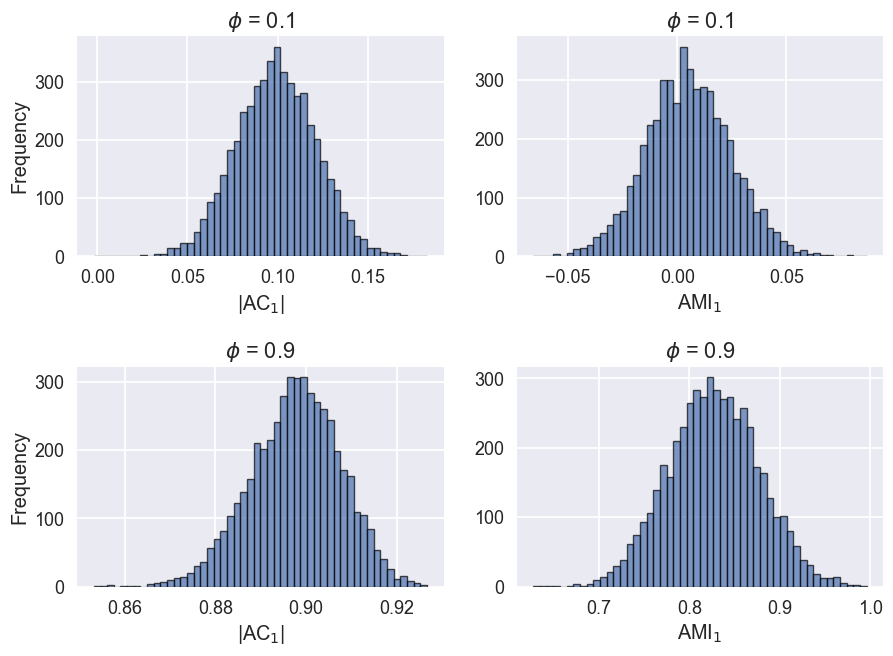

In [55]:
bins=50
alpha=0.7
lw=1
edgecolor='black'
plt.style.use("seaborn")
plt.style.use("seaborn-talk")
plt.figure()
plt.subplots_adjust(hspace=0.5, wspace=0.2)

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, i*2+j+1)
        print(i, j)
        plt.hist(AR_ACAMIresults[i][j], bins=bins, alpha=alpha, lw=lw, edgecolor=edgecolor)
        if j == 0:
            plt.xlabel(r'|AC$_1$|')
        else:
            plt.xlabel(r'AMI$_1$')

        plt.title(r'$\phi$ = ' + str(lag1para[i]))
        
        if j == 0:
            plt.ylabel('Frequency')
plt.savefig('ACAMInormaldistribution.svg', format='svg', dpi=1000)
